In [2]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
#import graphviz
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
#from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

In [3]:
LOCAL = '../data/tanzania/'
source = LOCAL

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


In [4]:
def wrangle(x):
    
    x = x.copy()

    # Convert date_recorded to datetime
    x['date_recorded_ts'] = pd.to_datetime(x['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    x['year'] = x['date_recorded_ts'].dt.year
    x['month'] = x['date_recorded_ts'].dt.month
    x['day'] = x['date_recorded_ts'].dt.day
    
    
    # Engineer feature: how many years from construction_year to date_recorded
    x['age'] = x['year'] - x['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    x = x.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    x = x.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    x['latitude'] = x['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        x[col] = x[col].replace(0, np.nan)

    return x

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [5]:
train.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'date_recorded_ts', 'year', 'month', 'day', 'age'],
      dtype='object')

In [6]:
# The status_group column is the target
target = 'status_group'



features = ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'scheme_management', 'scheme_name',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 
       'year', 'month', 'day', 'age']

     
#Excluded # RF doesent support ts var date_recorded_ts , status_group


#High cardinality
'''wpt_name                 30661
subvillage               17231
scheme_name               2563
ward                      2082
installer                 1929
funder                    1716
date_recorded              349
lga                        124
'''

'wpt_name                 30661\nsubvillage               17231\nscheme_name               2563\nward                      2082\ninstaller                 1929\nfunder                    1716\ndate_recorded              349\nlga                        124\n'

In [7]:
x_train = train[features]
y_train = train[target]
x_val = val[features]
y_val = val[target]
x_test = test[features]

In [8]:

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000,  n_jobs=-1))
# all 0.8135521885521886 0.8144781144781145 .8146464646464646 0.8142255892255892 0.8136363636363636


In [9]:
%%time

# Fit on train, score on val
pipeline.fit(x_train, y_train)

print('Validation Accuracy', pipeline.score(x_val, y_val))



Validation Accuracy 0.8143939393939394
CPU times: user 2min 44s, sys: 1.29 s, total: 2min 45s
Wall time: 13.3 s


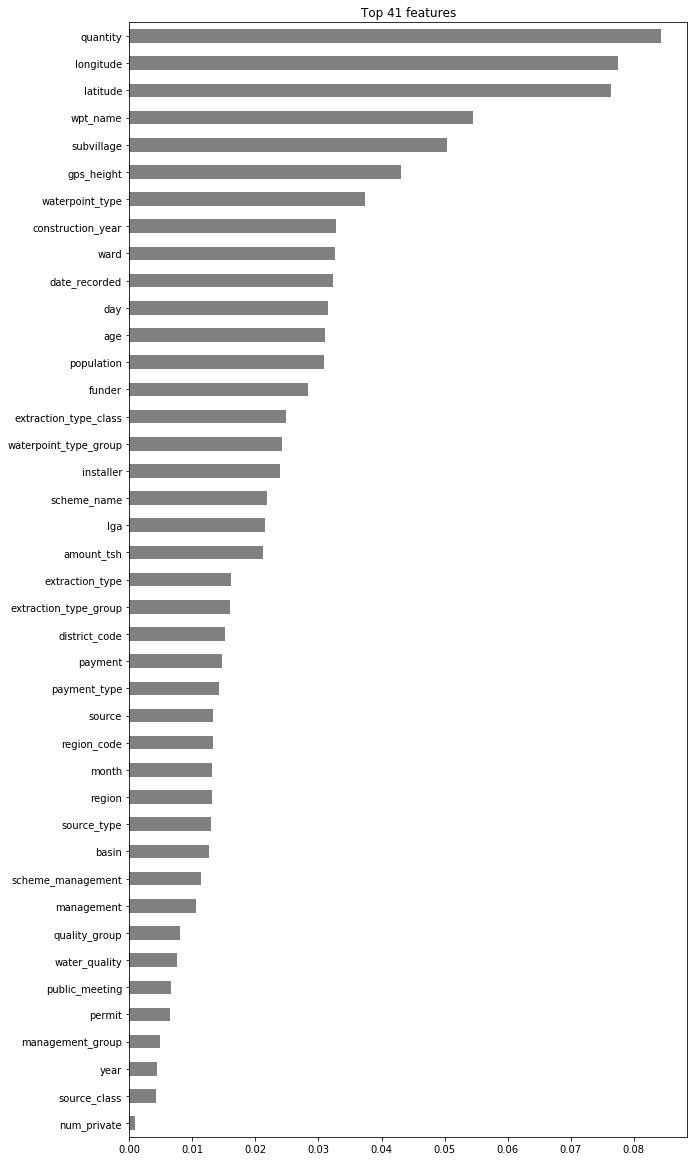

In [10]:
# TODO

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, x_train.columns)

# Plot feature importances
n = 41
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');


In [11]:
x_train.select_dtypes(exclude='number').nunique().sort_values(ascending=False)

wpt_name                 30661
subvillage               17231
scheme_name               2563
ward                      2082
installer                 1929
funder                    1716
date_recorded              349
lga                        124
region                      21
extraction_type             18
extraction_type_group       13
scheme_management           12
management                  12
source                      10
basin                        9
water_quality                8
payment_type                 7
extraction_type_class        7
waterpoint_type              7
source_type                  7
payment                      7
waterpoint_type_group        6
quality_group                6
quantity                     5
management_group             5
source_class                 3
public_meeting               2
permit                       2
dtype: int64

In [13]:

y_pred = pipeline.predict(x_test)

# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-05.csv', index=False)

In [15]:
! kaggle competitions submit -c ds5-predictive-modeling-challenge -f submission-05.csv -m "Random Forest"


100%|████████████████████████████████████████| 264k/264k [00:03<00:00, 75.5kB/s]
Successfully submitted to DS5 Predictive Modeling Challenge